In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import sqlite3

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model

# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()
inspector = inspect(engine)

In [7]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Save references to each table
Mes = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)
first_row = session.query(Mes).first()
print(first_row.__dict__)

first_row_station = session.query(Station).first()
print(first_row_station.__dict__)


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000205B1F35748>, 'prcp': 0.08, 'station': 'USC00519397', 'tobs': 65.0, 'date': '2010-01-01', 'id': 1}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000205B1F35A90>, 'elevation': 3.0, 'latitude': 21.2716, 'name': 'WAIKIKI 717.2, HI US', 'id': 1, 'longitude': -157.8168, 'station': 'USC00519397'}


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
cnx = sqlite3.connect('Resources/hawaii.sqlite')

df = pd.read_sql_query("SELECT * FROM measurement", cnx)
df


,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


In [12]:
# Find the most recent date in the data set.
recent = session.query(Mes.date).order_by(Mes.date.desc()).limit(1)
#print(f"The most recent date is: {recent}")

for row in recent:
    print(f"The most recent date is: {row[0]}")
    string_date = row[0]
print(string_date)

The most recent date is: 2017-08-23
2017-08-23


2016-08-23 00:00:00
2017-08-23 00:00:00


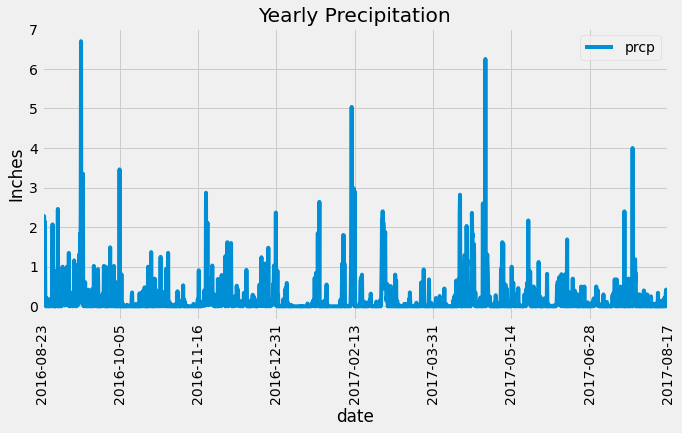

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
import datetime as dt

from datetime import datetime

datetime_object = datetime.strptime(string_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
last_year = datetime_object - dt.timedelta(days=365)
print(last_year)
# Perform a query to retrieve the data and precipitation scores
print(datetime_object)

# Save the query results as a Pandas DataFrame and set the index to the date column

query = session.query(Mes.date, Mes.prcp).filter(Mes.date >= (last_year - dt.timedelta(days=1))).\
    filter(Mes.date <= datetime_object).\
    order_by(Mes.date).all()


df = pd.DataFrame(query).dropna()

df.set_index('date', inplace = True)

ax = df.plot(rot = 90, figsize=(10,5), title = 'Yearly Precipitation', xlim = [0, 2000])
ax.set_ylabel('Inches')
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print(f"The mean prcp is: {df['prcp'].mean()} \nThe mode prcp is {df['prcp'].mean()}\nThe median prcp is {df['prcp'].median()}")

The mean prcp is: 0.17727857496288965 
The mode prcp is 0.17727857496288965
The median prcp is 0.02


# Exploratory Station Analysis

In [33]:
# Design a query to calculate the total number stations in the dataset
total_stat = session.query(Station.station).distinct(Station.station).count()
print(total_stat)

9


In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stat = session.query(Mes.station, func.count(Mes.station)).group_by(Mes.station).order_by((func.count(Mes.station).desc())).all()
stat

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
upside_down = session.query(Mes.station, func.count(Mes.station)).group_by(Mes.station).order_by((func.count(Mes.station).asc())).all()
for k,v in upside_down:
    most_active = k


most_active_q = session.query(Mes.station, func.min(Mes.tobs), func.avg(Mes.tobs), func.max(Mes.tobs)).\
                    filter(Mes.station == most_active).all()

print(most_active_q)


most_active_df = session.query(Mes.station, Mes.tobs).\
                    filter(Mes.station == most_active).all()

df = pd.DataFrame(most_active_df)

df.describe()

[('USC00519281', 54.0, 71.66378066378067, 85.0)]


,tobs
count,2772.000000
mean,71.663781
std,4.357642
min,54.000000
25%,69.000000
50%,72.000000
75%,74.000000
max,85.000000


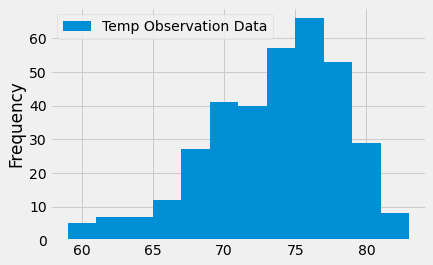

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12 = session.query(Mes.date, Mes.station, Mes.tobs,).\
                    filter(Mes.station == most_active).\
                    filter(Mes.date >= (last_year - dt.timedelta(days=1))).\
                    filter(Mes.date <= datetime_object).\
                    order_by(Mes.date).all()

last_12_df = pd.DataFrame(last_12)
last_12_df = last_12_df.rename(columns = {'tobs': 'Temp Observation Data'})
hist = last_12_df.plot.hist(bins=12)

# Close session

In [19]:
# Close Session
session.close()